In [24]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits
import pymaster as nmt
import sys
import os
import time

# Loading the realisations of datasets

In [2]:
# Read the dataset, It will contain only temperature data at this moment
def read_data(filename):
    data = hp.read_map(filename)
    return

# Calculate mean and variance of the power specrum, ps_data will be a dictionary containing the power spectrum data
def calc_mean_var(ps_data):
    mean = np.mean(ps_data)
    var = np.var(ps_data)
    return mean, var

In [3]:
# For multiple files, they are draw from the same cosmolocial parameters, so we can combine them and calculate 
# the mean and variance of the sets

def combine_files(filenames):
    n = len(filenames)
    map_data = {}
    ps_data = {}
    for i in range(n):
        map_data[f'{i}'] = read_data(filenames[i])
        ps_data[f'{i}'] = hp.anafast(map_data[f'{i}'])
    mean, var = calc_mean_var(ps_data)
    return mean, var

# Cosmic variance and noise power spectrum will consist of the total variance of the power spectrum

In [4]:
# define the function to calculate the cosmic variance
def calc_cosmic_variance(cl,fsky):
    ell = np.arange(len(cl))
    return cl*np.sqrt(2/((2*ell+1)*fsky))

# define the function to calculate the noise variance
def calc_noise_variance(nl,fsky):
    ell = np.arange(len(nl))
    return nl*np.sqrt(2/((2*ell+1)*fsky))

def calc_total_variance(cl,nl,fsky):
    return calc_cosmic_variance(cl,fsky) + calc_noise_variance(nl,fsky)

In [5]:
# The cls are the mean of the realizations, the nls are the variance of the noise realizations
def get_error_bars(cl, nl, fsky):
    total_variance = calc_total_variance(cl,nl,fsky)
    return total_variance

# Make a test with the Planck NILC CMB and Planck's simulation

In [6]:
# Paths for the Planck data
noise_dir  = '/home/yunan/planck_release/'
assets_dir = '/shared/data/Assets/Planck/'
Planck_noise_sim_path = {'30' : noise_dir +'ffp10_noise_030_full_map_mc_00000.fits',
                         '44' : noise_dir +'ffp10_noise_044_full_map_mc_00000.fits',
                         '70' : noise_dir +'ffp10_noise_070_full_map_mc_00000.fits',
                         '100': noise_dir +'ffp10_noise_100_full_map_mc_00000.fits',
                         '143': noise_dir +'ffp10_noise_143_full_map_mc_00000.fits',
                         '217': noise_dir +'ffp10_noise_217_full_map_mc_00000.fits',
                         '353': noise_dir +'ffp10_noise_353_full_map_mc_00000.fits',
                         '545': noise_dir +'ffp10_noise_545_full_map_mc_00000.fits',
                         '857': noise_dir +'ffp10_noise_857_full_map_mc_00000.fits'}

Planck_cmb_nilc_path = assets_dir +'COM_CMB_IQU-nilc_2048_R3.00_full.fits'

In [7]:
Planck_cmb_nilc_map = hp.read_map(Planck_cmb_nilc_path)
Planck_noise_sim_map = {}
for freq in Planck_noise_sim_path:
    Planck_noise_sim_map[freq] = hp.read_map(Planck_noise_sim_path[freq])
    if freq == '545' or freq == '857':
        t_mjy_sr = 1 *u.MJy/u.sr
        converting_fatcor = t_mjy_sr.to(u.uK, equivalencies=u.thermodynamic_temperature(float(freq) * u.GHz))
        Planck_noise_sim_map[freq] = Planck_noise_sim_map[freq]*converting_fatcor

In [8]:
# Calculate the power spectrum of the CMB map and the noise maps
nside = hp.get_nside(Planck_cmb_nilc_map)
ellmax = 2*nside
Planck_cmb_nilc_ps = hp.anafast(Planck_cmb_nilc_map, lmax=ellmax)
Planck_noise_sim_ps = {}
for freq in Planck_noise_sim_map:
    Planck_noise_sim_ps[freq] = hp.anafast(Planck_noise_sim_map[freq], lmax=ellmax)

In [9]:
# Calculate the combined power spectrum for the noise
nl = np.zeros(ellmax + 1)
nl_temp = np.zeros(ellmax + 1)
for freq in Planck_noise_sim_ps:
    nl_temp += 1/Planck_noise_sim_ps[freq]
nl = 1/nl_temp

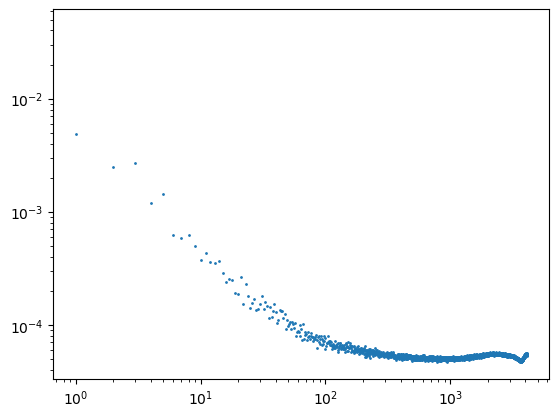

In [10]:
ells = np.arange(ellmax + 1)
norm_factor = (ells*(ells+1))/(2*np.pi)
Planck_cmb_nilc_dl = Planck_cmb_nilc_ps*norm_factor
#plt.scatter(ells, Planck_cmb_nilc_dl, s = 1, label = 'CMB')
plt.scatter(ells, nl*10**12, s = 1, label = 'noise')
plt.yscale('log')
plt.xscale('log')
plt.show()


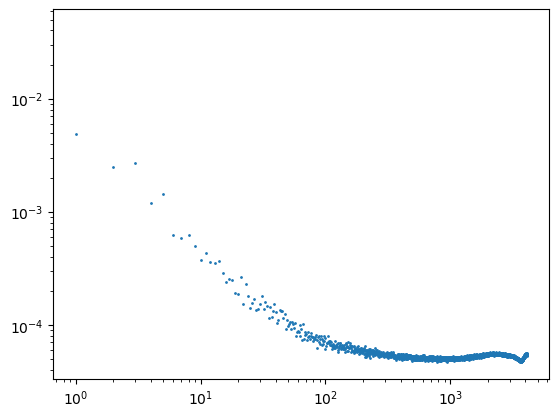

In [11]:
ells = np.arange(ellmax + 1)
norm_factor = (ells*(ells+1))/(2*np.pi)
Planck_cmb_nilc_dl = Planck_cmb_nilc_ps*norm_factor
#plt.scatter(ells, Planck_cmb_nilc_dl, s = 1, label = 'CMB')
plt.scatter(ells, nl*10**12, s = 1, label = 'noise')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [12]:
# Combine the noise power spectrum and the CMB power spectrum
total_error_bars = get_error_bars(Planck_cmb_nilc_ps*10**12, nl*10**12, 1)

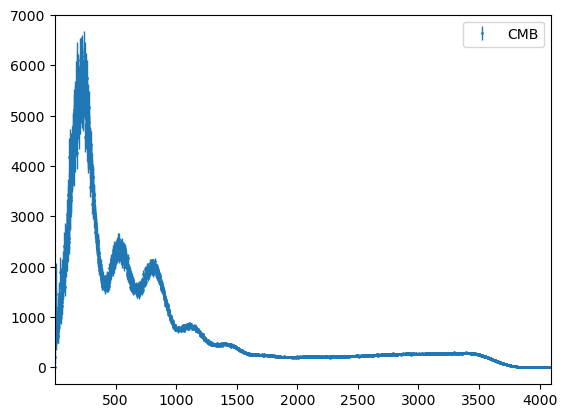

In [13]:
#plot the error bars with the CMB power spectrum
plt.errorbar(ells, Planck_cmb_nilc_dl*10**12, yerr = norm_factor*total_error_bars, fmt = 'o',markersize = 1, elinewidth = 1, label = 'CMB')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlim(2,ellmax)
plt.show()


In [14]:
file_path = '/home/yunan/planck_release/planck_mask.fits'
hp.read_map(file_path)
mask = hp.read_map(file_path, field = 0)

In [45]:
# Apodize the mask
aposcale = 1 # degrees
mask_c1 = nmt.mask_apodization(mask, aposcale, apotype='C1')

In [46]:
mask_nside = hp.get_nside(mask)
fsky1 = np.sum(mask_c1)/len(mask_c1)
fsky2 = np.sum(mask_c1**2)/(len(mask_c1))
print(fsky1,fsky2)

0.768964099748993 0.7651621627703022


In [32]:
def get_power(mapp1,mapp2,mask,lmax=None):
    mean1 = np.sum(mapp1*mask)/np.sum(mask)
    mean2 = np.sum(mapp2*mask)/np.sum(mask)
    fsky = np.sum(mask**2)/mask.shape[0]
    return hp.anafast(mask*(mapp1-mean1),mask*(mapp2-mean2),lmax=lmax)/fsky

def nomr_ps(ps, beam, ellmax):    
    ell = np.arange(len(ps))
    dl = ell*(ell+1)*ps/(2*np.pi)/beam**2
    return ell, dl

def calcu_dl(map1, map2, mask, beam, ellmax):
    ps = get_power(map1, map2, mask, lmax=ellmax)
    ell, dl = nomr_ps(ps, beam, ellmax)
    dl[0:2] = 0
    return ell, dl

In [17]:
hdul = fits.open(Planck_cmb_nilc_path)
hdul.info()
data = hdul[2].data
planck_beam = data['INT_BEAM']

Filename: /shared/data/Assets/Planck/COM_CMB_IQU-nilc_2048_R3.00_full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1                1 BinTableHDU     59   50331648R x 8C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
  2                1 BinTableHDU     18   4097R x 2C   [1E, 1E]   


In [47]:
ell, Planck_cmb_nilc_dl_masked = calcu_dl(Planck_cmb_nilc_map, Planck_cmb_nilc_map, mask_c1, planck_beam, ellmax=ellmax)

/tmp/ipykernel_371149/2926504513.py:9: RuntimeWarning: divide by zero encountered in divide
  dl = ell*(ell+1)*ps/(2*np.pi)/beam**2
/tmp/ipykernel_371149/2926504513.py:9: RuntimeWarning: invalid value encountered in divide
  dl = ell*(ell+1)*ps/(2*np.pi)/beam**2


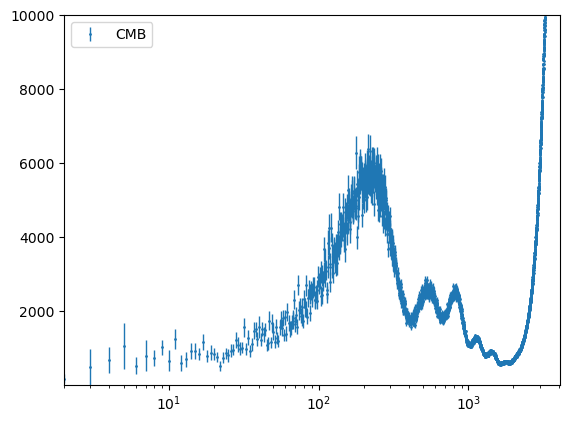

In [19]:
#plot the error bars with the CMB power spectrum
plt.errorbar(ells, Planck_cmb_nilc_dl_masked*10**12, yerr = norm_factor*total_error_bars, fmt = 'o',markersize = 1, elinewidth = 1, label = 'CMB')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlim(2,ellmax)
plt.ylim(1,10000)
plt.show()


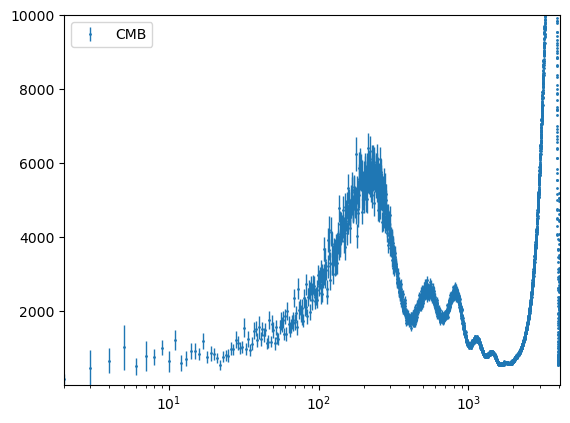

In [48]:
#plot the error bars with the CMB power spectrum
plt.errorbar(ells, Planck_cmb_nilc_dl_masked*10**12, yerr = norm_factor*total_error_bars, fmt = 'o',markersize = 1, elinewidth = 1, label = 'CMB')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlim(2,ellmax)
plt.ylim(1,10000)
plt.show()


In [50]:
ell, planck_dl, delta_minus_dl, delta_plus_dl = np.genfromtxt('/home/yunan/COM_PowerSpect_CMB-TT-full_R3.01.txt', unpack=True)

In [37]:
asymmetric_error = [delta_minus_dl, delta_plus_dl]

In [38]:
noise_residual = -planck_dl +Planck_cmb_nilc_dl_masked[:2507]*10**12

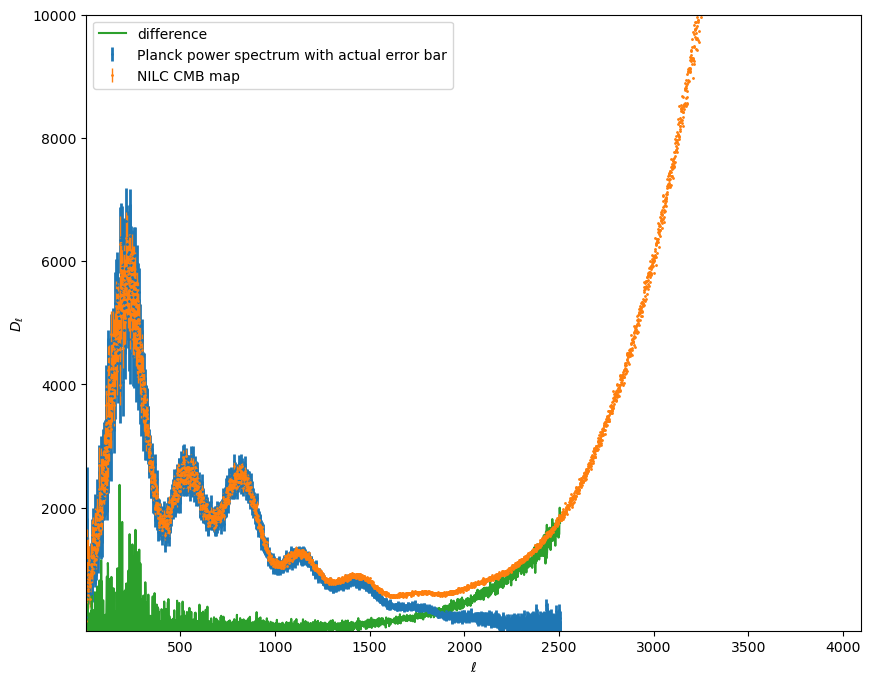

In [23]:
plt.figure(figsize=(10, 8))

# Plot the data with error bars
plt.errorbar(ell, planck_dl, yerr=asymmetric_error, fmt='o', markersize=1, elinewidth=2, label='Planck power spectrum with actual error bar')
plt.errorbar(ells, Planck_cmb_nilc_dl_masked*10**12, yerr = norm_factor*total_error_bars, fmt = 'o',markersize = 1, elinewidth = 1, label = 'NILC CMB map')
plt.plot(noise_residual, label = 'difference')

# Add labels and legend
#plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell$')
plt.legend()
plt.xlim(2,ellmax)
plt.ylim(1,10000)
# Show the plot
plt.show()

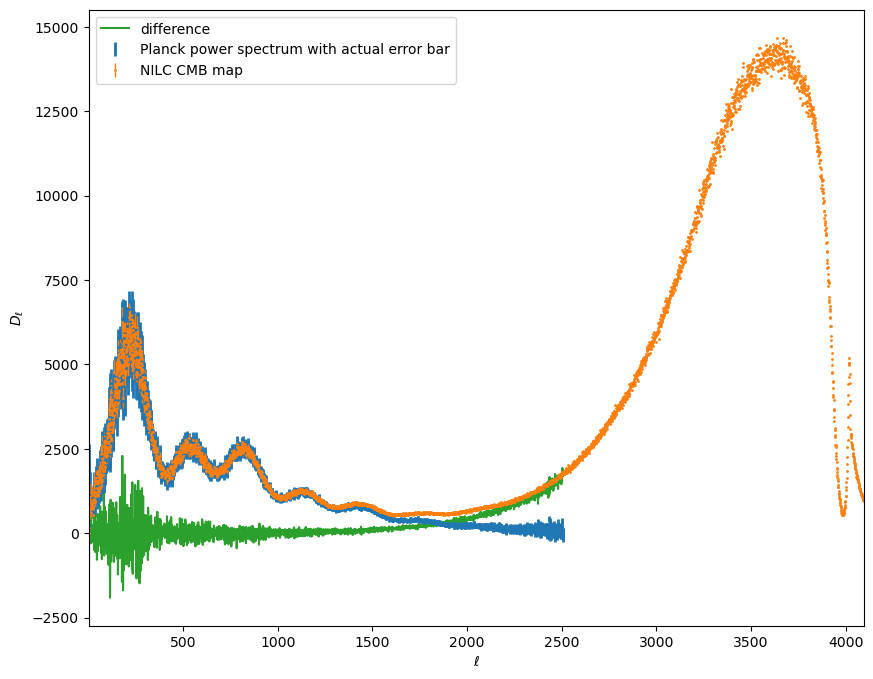

In [51]:
plt.figure(figsize=(10, 8))

# Plot the data with error bars
plt.errorbar(ell, planck_dl, yerr=asymmetric_error, fmt='o', markersize=1, elinewidth=2, label='Planck power spectrum with actual error bar')
plt.errorbar(ells, Planck_cmb_nilc_dl_masked*10**12, yerr = norm_factor*total_error_bars, fmt = 'o',markersize = 1, elinewidth = 1, label = 'NILC CMB map')
plt.plot(noise_residual, label = 'difference')

# Add labels and legend
#plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell$')
plt.legend()
plt.xlim(2,ellmax)
#plt.ylim(1,10000)
# Show the plot
plt.show()